In [1]:
from fore_utils import WeatherData

from torch.utils.data import DataLoader

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from IPython.display import HTML

import cartopy.crs as ccrs

import torch
from torch.utils.data import Dataset

from typing import Tuple

# Add settings to choose variables and spatial extent

class WeatherData(Dataset):
    def __init__(self, 
                 window_size: int = 24, 
                 step_size: int = 12, 
                 set:str = 'train', 
                 area: Tuple[int, int] = (-31.667, 18.239), 
                 spaces: int = 0, 
                 intervals: int = 1,
                 lightning: bool = False,
                 series_target: bool = False,
                 verbose: bool = False):
        '''

        Data format:
            0 - humidity
            1 - temperature
            2 - u-wind
            3 - v-wind
            4 - w-wind

        '''
        print('10%', end='\r')

        # Extract correct dataset
        if set == 'train':
            years = ['2018', '2019', '2020', '2021']
        elif set == 'val':
            years = ['2022']
        elif set == 'test':
            years = ['2023']

        if lightning:

            self.og_data = np.concatenate([np.load(f'forecasting_experiments/datasets/{year}_850_SA.npy') for year in years], axis=1)
            self.og_data = self.data.transpose(1, 2, 3, 0)

            self.times = np.concatenate([np.load(f'forecasting_experiments/datasets/{year}_850_SA_times.npy') for year in years])

            self.og_lon = np.load('forecasting_experiments/datasets/SA_lon.npy')
            self.og_lat = np.load('forecasting_experiments/datasets/SA_lat.npy')

        else:
            self.og_data = np.concatenate([np.load(f'datasets/{year}_850_SA.npy') for year in years], axis=1)
            self.og_data = self.og_data.transpose(1, 2, 3, 0)

            self.times = np.concatenate([np.load(f'datasets/{year}_850_SA_times.npy') for year in years])

            self.og_lon = np.load('datasets/SA_lon.npy')
            self.og_lat = np.load('datasets/SA_lat.npy')

        print('40%', end='\r')


        self.spaces = spaces
        self.area = area

        self.series_target = series_target
        
        self.window_size = window_size
        self.step_size = step_size

        self.intervals = intervals

        self.verbose = verbose

        # self.re_init()

        if self.verbose:
            print(f'Details for {set} set:')

            print(f'Data from {years} loaded')

    def __len__(self):
        return self.data.shape[0] - self.window_size - self.step_size + 1

    def __getitem__(self, idx):
            return self.features[idx : idx + self.window_size], self.targets[idx : idx + self.window_size],self.targets[idx + self.window_size : idx + self.window_size + self.step_size]
    
    def re_init(self):
        self.lon = self.og_lon
        self.lat = self.og_lat
        self.data = self.og_data


        self.get_area(self.area)

        print('50%', end='\r')

        if self.spaces != 0:
            q = self.data[:, :, :, 0]
            t = self.data[:, :, :, 1]
            u = self.data[:, :, :, 2]
            v = self.data[:, :, :, 3]
            w = self.data[:, :, :, 4]
        else:
            q = self.data[:,0]
            t = self.data[:,1]
            u = self.data[:,2]
            v = self.data[:,3]
            w = self.data[:,4]
            self.series_target = False

        q, t, u, v, w = self.normalize(q, t, u, v, w)

        print('65%', end='\r')

        self.calculate_wind(u, v)

        print('80%', end='\r')

        if self.series_target:
            self.features = torch.tensor(np.stack([q, t, u, v, w], axis=-1), dtype=torch.float32)
        else:
            self.features = torch.tensor(np.stack([q, t, u, v, w, self.wspd], axis=-1), dtype=torch.float32)

        self.targets = torch.tensor(self.wspd, dtype=torch.float32)

        print('100%', end='\r')

        if self.verbose:
            print(f'Features shape: {self.features.shape}')
            print(f'Targets shape: {self.targets.shape}')

            print(f'Longitudes: {self.lon}')
            print(f'Latitudes: {self.lat}')

    def normalize(self, q, t, u, v, w, method = 'std'): 
        if method == 'std':
            q = (q - q.mean()) / q.std()
            t = (t - t.mean()) / t.std()
            u = (u - u.mean()) / u.std()
            v = (v - v.mean()) / v.std()
            w = (w - w.mean()) / w.std()

        return q, t, u, v, w        
    
    def calculate_wind(self, u, v):
        if self.series_target:
            u = u[:, u.shape[1]//2, u.shape[2]//2]
            v = v[:, v.shape[1]//2, v.shape[2]//2]

        self.wspd = np.sqrt(u**2 + v**2)
        # self.wdir = np.arctan2(u, v)

    def get_area(self, area: Tuple[int, int]):
        lon = np.argmin(np.abs(self.lon - area[1]))

        lat = np.argmin(np.abs(self.lat - area[0]))

        if self.spaces != 0:

            self.lon = self.lon[lon - self.spaces:lon + self.spaces]
            self.lat = self.lat[lat - self.spaces: lat + self.spaces]

            self.data = self.og_data[:, lat - self.spaces: lat + self.spaces, lon - self.spaces:lon + self.spaces, :]
        else:

            self.lon = self.lon[lon]
            self.lat = self.lat[lat]

            self.data = self.og_data[:, lat, lon, :]

    def plot_area(self):
        if self.spaces != 0:
            fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

            ax.coastlines()

            ax.set_extent([self.lon.min(), self.lon.max(), self.lat.min(), self.lat.max()])

            lon, lat = self.lon, self.lat
            contour = ax.contourf(lon, lat, self.targets[0].detach().numpy(), transform=ccrs.PlateCarree())

            fig.colorbar(contour, ax=ax, orientation='vertical', label='Wind Speed (m/s)')

            plt.show()
        else:
            print('Cannot plot area with only one point')

    def plot_animation(self, seed: int = 0, frame_rate: int = 16, levels: int = 10) -> HTML:
        """
        Plots features and targets from the windowed arrays for visualization.

        Args:
            seed (int): Seed for reproducibility in selecting samples. Default is 0.
            frame_rate (int): The frame rate for the animation. Default is 16.
            levels (int): Number of contour levels for the plot. Default is 10.

        Returns:
            HTML: An HTML object representing the animation.
        """
        if self.spaces != 0:
            bounds = [self.lon.min(), self.lon.max(), self.lat.min(), self.lat.max()]

            features = self.features[seed:seed + self.window_size * self.intervals:self.intervals]
            targets = self.targets[seed + self.window_size * self.intervals:seed + (self.window_size + self.step_size) * self.intervals: self.intervals]
            
            time_features = self.times[seed:seed + self.window_size * self.intervals:self.intervals]
            time_targets = self.times[seed + self.window_size * self.intervals:seed + (self.window_size + self.step_size) * self.intervals: self.intervals]

            time_features = pd.to_datetime(time_features)
            time_targets = pd.to_datetime(time_targets)

            fig, axs = plt.subplots(1, 2, figsize=(21, 7), subplot_kw={'projection': ccrs.PlateCarree()})

            vmin = min(features.min().item(), targets.min().item())
            vmax = max(features.max().item(), targets.max().item())

            fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.2)

            for ax in axs:
                ax.set_extent(bounds, crs=ccrs.PlateCarree())
                ax.coastlines()

            feat = axs[0].contourf(self.lon, self.lat, features[0, :, :, 2], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
            tar = axs[1].contourf(self.lon, self.lat, targets[0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
            axs[1].set_title('Target')

            fig.colorbar(feat, ax=axs[0], orientation='vertical', label='Wind Speed (m/s)')
            fig.colorbar(tar, ax=axs[1], orientation='vertical', label='Wind Speed (m/s)')

            def animate(i):
                axs[0].clear()
                axs[0].coastlines()

                axs[0].contourf(self.lon, self.lat, features[i, :, :, 2], levels=levels, vmin=vmin, vmax = vmax)

                axs[0].set_title(f'Window {i} - {time_features[i].strftime("%Y-%m-%d %H:%M:%S")}')
                if self.step_size > 1:
                    axs[1].contourf(self.lon, self.lat, targets[i % self.step_size], levels=levels, vmin=vmin, vmax = vmax)
                    axs[1].set_title(f'Target - {time_targets[i % self.step_size].strftime("%Y-%m-%d %H:%M:%S")}')
                # return pcm

                
            frames = features.shape[0]

            interval = 1000 / frame_rate

            ani = FuncAnimation(fig, animate, frames=frames, interval=interval)

            plt.close(fig)

            return HTML(ani.to_jshtml())
        else:
            print('Cannot plot area with only one point')

    def plot_point(self, seed: int = 0):
        if self.spaces == 0:
            plt.figure(figsize=(10, 5))

            plt.plot(self.times[seed:seed + self.window_size], self.features[seed:seed + self.window_size, 0], label='Humidity')
            plt.plot(self.times[seed:seed + self.window_size], self.features[seed:seed + self.window_size, 1], label='Temperature')
            plt.plot(self.times[seed:seed + self.window_size], self.features[seed:seed + self.window_size, 2], label='U-Wind')
            plt.plot(self.times[seed:seed + self.window_size], self.features[seed:seed + self.window_size, 3], label='V-Wind')
            plt.plot(self.times[seed:seed + self.window_size], self.features[seed:seed + self.window_size, 4], label='W-Wind')
            plt.plot(self.times[seed:seed + self.window_size], self.features[seed:seed + self.window_size, 5], label='Wind Speed', linestyle='--')

            plt.plot(self.times[seed + self.window_size:seed + self.window_size + self.step_size], self.targets[seed + self.window_size:seed + self.window_size + self.step_size], label='Wind Speed', linestyle='--')
            
            plt.xticks(rotation=45)
            plt.legend()
            plt.show()
        else:
            print('Cannot plot point with multiple points')        

    def plot_prediction(self, model, seed: int = 0, frame_rate: int = 16, levels: int = 10) -> HTML:
        if self.spaces != 0:
            bounds = [self.lon.min(), self.lon.max(), self.lat.min(), self.lat.max()]

            features = self.features[seed:seed + self.window_size * self.intervals:self.intervals]
            targets = self.targets[seed + self.window_size * self.intervals:seed + (self.window_size + self.step_size) * self.intervals: self.intervals].detach().numpy()   

            predictions = model(features.unsqueeze(0)).detach().numpy().squeeze()

            time_targets = self.times[seed + self.window_size * self.intervals:seed + (self.window_size + self.step_size) * self.intervals: self.intervals]

            time_targets = pd.to_datetime(time_targets)

            
            fig, axs = plt.subplots(2, 3, figsize=(21, 7), subplot_kw={'projection': ccrs.PlateCarree()})

            vmin = min(predictions.min().item(), targets.min().item())
            vmax = max(predictions.max().item(), targets.max().item())

            fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.2)

            for ax in axs.flatten()[:-1]:
                ax.set_extent(bounds, crs=ccrs.PlateCarree())
                ax.coastlines()

            ax_last = fig.add_subplot(2, 3, 6)

            print('Predictions:', predictions.shape)
            print('Targets:', targets.shape)

            pred = axs[0, 0].contourf(self.lon, self.lat, predictions[0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
            tar = axs[0, 1].contourf(self.lon, self.lat, targets[0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())

            error = (predictions[0] - targets[0].squeeze()) 

            err = axs[0, 2].contourf(self.lon, self.lat, error.squeeze(), levels=levels, transform=ccrs.PlateCarree(), cmap='coolwarm')

            perc_error = error / targets[0,0].squeeze() * 100
            perc_error = np.clip(perc_error, -100, 100)
            rmse = np.sqrt(error**2)

            perr = axs[1, 0].contourf(self.lon, self.lat, perc_error, levels=levels, transform=ccrs.PlateCarree(), cmap='coolwarm')
            rms = axs[1, 1].contourf(self.lon, self.lat, rmse, levels=levels, transform=ccrs.PlateCarree(), cmap='coolwarm')
            ax_last.scatter(targets[0].flatten(), predictions[0].flatten(), c=error, cmap='coolwarm')

            fig.colorbar(pred, ax=axs[0, 0], orientation='vertical', label='Wind Speed (m/s)')
            fig.colorbar(tar, ax=axs[0, 1], orientation='vertical', label='Wind Speed (m/s)')
            fig.colorbar(err, ax=axs[0, 2], orientation='vertical', label='Percentage Error (%)')
            fig.colorbar(perr, ax=axs[1, 0], orientation='vertical', label='Percentage Error (%)')
            fig.colorbar(rms, ax=axs[1, 1], orientation='vertical', label='Root Mean Squared Error (m/s)')

            ax_last.set_xlabel("Observed Wind Speed (m/s)")
            ax_last.set_ylabel("Forecasted Wind Speed (m/s)")

            def animate(i):
                for ax in axs.flatten()[:-1]:
                    ax.clear()
                    ax.coastlines()
                
                ax_last.clear()
                ax_last.set_xlabel("Observed Wind Speed (m/s)")
                ax_last.set_ylabel("Forecasted Wind Speed (m/s)")

                axs[0, 0].contourf(self.lon, self.lat, predictions[i], levels=levels, vmin=vmin, vmax = vmax)
                axs[0, 1].contourf(self.lon, self.lat, targets[i], levels=levels, vmin=vmin, vmax = vmax)
                
                error =  (predictions[i] - targets[i].squeeze())
                axs[0, 2].contourf(self.lon, self.lat, error, levels=levels, transform=ccrs.PlateCarree(), cmap='coolwarm')
                
                perc_error = error / targets[i % self.step_size].squeeze() * 100
                perc_error = np.clip(perc_error, -100, 100)
                rmse = np.sqrt(error**2)

                axs[1, 0].contourf(self.lon, self.lat, perc_error, levels=levels, transform=ccrs.PlateCarree(), cmap='coolwarm')
                axs[1, 1].contourf(self.lon, self.lat, rmse, levels=levels, transform=ccrs.PlateCarree(), cmap='coolwarm')
                ax_last.scatter(targets[i].flatten(), predictions[i].flatten(), c=error, cmap='coolwarm')

                axs[0, 0].set_title(f'Prediction {i} - {time_targets[i].strftime("%Y-%m-%d %H:%M:%S")}')  
                axs[0, 1].set_title(f'Target - {time_targets[i].strftime("%Y-%m-%d %H:%M:%S")}')
                axs[0, 2].set_title(f'Error - {time_targets[i].strftime("%Y-%m-%d %H:%M:%S")}')
                axs[1, 0].set_title(f'Percentage Error - {time_targets[i].strftime("%Y-%m-%d %H:%M:%S")}')
                axs[1, 1].set_title(f'Root Mean Squared Error - {time_targets[i].strftime("%Y-%m-%d %H:%M:%S")}')
                ax_last.set_title(f'Error Scatter Plot - {time_targets[i].strftime("%Y-%m-%d %H:%M:%S")}')

            frames = predictions.shape[0]

            interval = 1000 / frame_rate

            ani = FuncAnimation(fig, animate, frames=frames, interval=interval)

            plt.close(fig)

            return HTML(ani.to_jshtml())

        else:
            print('Cannot plot area with only one point')

In [2]:
window_size = 24
steps = 24
spaces = 5
hidden_size = 32
batch_size = 64
series_target = False
verbose = True

# If on lightining AI
lightning = False

# train_set = WeatherData(window_size=window_size, step_size=steps, set='train', spaces=spaces, lightning=lightning, series_target=series_target, verbose=verbose)
    
train_set = WeatherData(window_size=window_size, step_size=steps, set='val', spaces=spaces, lightning=lightning, series_target=series_target, verbose=verbose)

dataset_config = {
    "window_size" : [train_set.window_size],
    "step_size" : [train_set.step_size],
    "spaces" : [train_set.spaces],
    "batch_size": [batch_size],
    "series_target": [train_set.series_target]
}


Details for val set:
Data from ['2022'] loaded


Features shape: torch.Size([8760, 6])
Targets shape: torch.Size([8760])
Longitudes: 18.3061580657959
Latitudes: -31.636999130249023


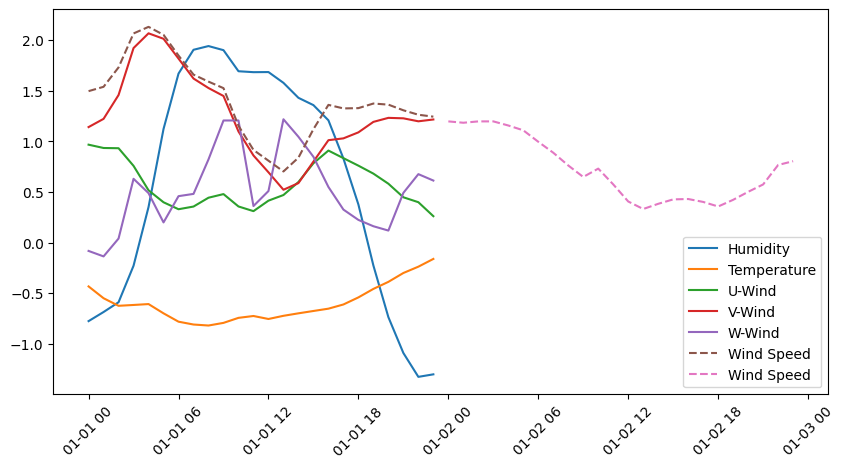

In [3]:
# For spaces = 0
train_set.spaces = 0

train_set.re_init()

train_set.plot_point()

In [4]:
train_set.spaces = 3

train_set.re_init()

train_set.plot_animation()

Features shape: torch.Size([8760, 6, 6, 6])
Targets shape: torch.Size([8760, 6, 6])
Longitudes: [17.556114 17.80613  18.056143 18.306158 18.556171 18.806185]
Latitudes: [-30.887 -31.137 -31.387 -31.637 -31.887 -32.137]


In [9]:
from torch.utils.data import DataLoader

window_size = 24
steps = 24
spaces = 0
batch_size = 64
series_target = True
verbose = False

train_set.window_size = window_size
train_set.step_size = steps
train_set.spaces = spaces
train_set.series_target = series_target
train_set.verbose = verbose

train_set.re_init()

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

for batch in train_loader:
    x, b, y = batch
    break

print('x: ', x.shape)
print('b: ', b.shape)
print('y: ', y.shape)

x:  torch.Size([64, 24, 6])
b:  torch.Size([64, 24])
y:  torch.Size([64, 24])


In [ ]:
import torch.nn as nn

